# Unet

In [ ]:
!pip install -Uq segmentation-models-pytorch torchmetrics kaggle

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 49.8 MB/s eta 0:00:00


In [ ]:
# Kaggle setup and dataset download
!mkdir ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d soumikrakshit/nyu-depth-v2
!unzip nyu-depth-v2.zip -d /content/nyu-depth-v2

Streaming output truncated to the last 5000 lines.
  inflating: /content/nyu-depth-v2/nyu_data/data/nyu2_train/playroom_0004_out/32.jpg  
  inflating: /content/nyu-depth-v2/nyu_data/data/nyu2_train/playroom_0004_out/32.png  
  inflating: /content/nyu-depth-v2/nyu_data/data/nyu2_train/playroom_0004_out/33.jpg  
  inflating: /content/nyu-depth-v2/nyu_data/data/nyu2_train/playroom_0004_out/33.png  
  inflating: /content/nyu-depth-v2/nyu_data/data/nyu2_train/playroom_0004_out/34.jpg  
  inflating: /content/nyu-depth-v2/nyu_data/data/nyu2_train/playroom_0004_out/34.png  
  inflating: /content/nyu-depth-v2/nyu_data/data/nyu2_train/playroom_0004_out/35.jpg  
  inflating: /content/nyu-depth-v2/nyu_data/data/nyu2_train/playroom_0004_out/35.png  
  inflating: /content/nyu-depth-v2/nyu_data/data/nyu2_train/playroom_0004_out/36.jpg  
  inflating: /content/nyu-depth-v2/nyu_data/data/nyu2_train/playroom_0004_out/36.png  
  inflating: /content/nyu-depth-v2/nyu_data/data/nyu2_train/playroom_0004_out/3

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
import cv2 as cv
from PIL import Image
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.regression import MeanSquaredError as MSE
from torchmetrics.collections import MetricCollection
import gc
from torchvision.transforms import Normalize

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
train_csv = Path('/content/nyu-depth-v2/nyu_data/data/nyu2_train.csv')
train_ims_path = Path('/content/nyu-depth-v2/nyu_data/data/nyu2_train')
base_path = Path('/content/nyu-depth-v2/nyu_data')
df = pd.read_csv(train_csv,header=None)
df[0] = df[0].map(lambda x:base_path/x)
df[1] = df[1].map(lambda x:base_path/x)
df.head()

0  \
0  /content/nyu-depth-v2/nyu_data/data/nyu2_train...   
1  /content/nyu-depth-v2/nyu_data/data/nyu2_train...   
2  /content/nyu-depth-v2/nyu_data/data/nyu2_train...   
3  /content/nyu-depth-v2/nyu_data/data/nyu2_train...   
4  /content/nyu-depth-v2/nyu_data/data/nyu2_train...   

                                                   1  
0  /content/nyu-depth-v2/nyu_data/data/nyu2_train...  
1  /content/nyu-depth-v2/nyu_data/data/nyu2_train...  
2  /content/nyu-depth-v2/nyu_data/data/nyu2_train...  
3  /content/nyu-depth-v2/nyu_data/data/nyu2_train...  
4  /content/nyu-depth-v2/nyu_data/data/nyu2_train...

In [ ]:
train_df, val_df = train_test_split(df,test_size=0.1,shuffle=True)
val_df, test_df = train_test_split(val_df, test_size=0.1,shuffle=True)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)
train_df=train_df[0:10000]
val_df=val_df[0:1000]
len(train_df),len(val_df), len(test_df)

(10000, 1000, 507)

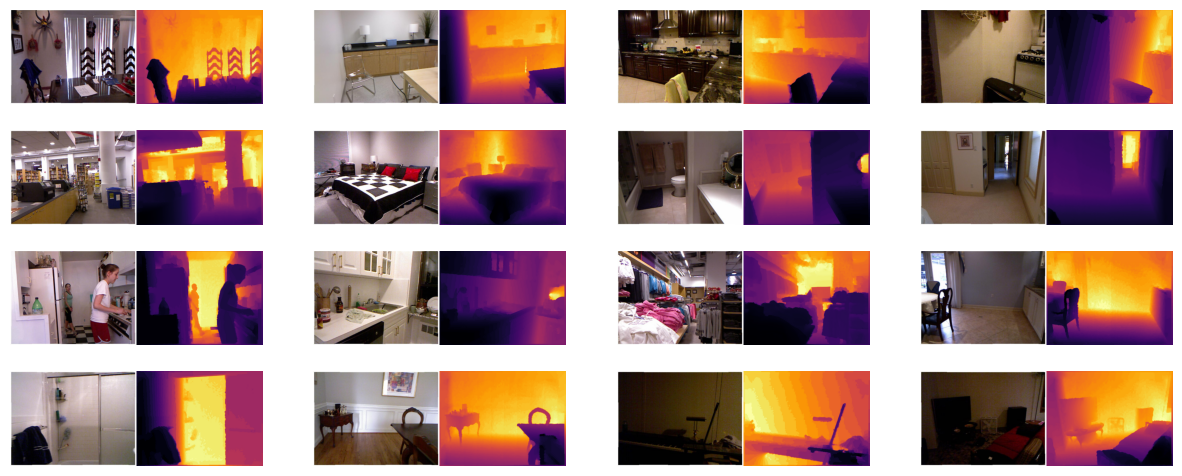

In [ ]:
def colored_depthmap(depth, d_min=None, d_max=None,cmap=plt.cm.inferno):
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:,:,:3] # H, W, C

def merge_into_row(input, depth_target):
    input = np.array(input)
    depth_target = np.squeeze(np.array(depth_target))

    d_min = np.min(depth_target)
    d_max = np.max(depth_target)
    depth_target_col = colored_depthmap(depth_target, d_min, d_max)
    img_merge = np.hstack([input, depth_target_col])

    return img_merge

plt.figure(figsize=(15, 6))
for i, idx in enumerate(np.random.randint(0,len(df),(16,))):
    ax = plt.subplot(4, 4, i + 1)
    image = Image.open(df.iloc[idx,0]).convert('RGB')
    mask = Image.open(df.iloc[idx,1]).convert('L')
    image_viz = merge_into_row(
        image,mask
    )
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

In [ ]:
sample_tfms = [
    A.HorizontalFlip(),
    A.GaussNoise(p=0.2),
    A.OneOf([
        A.MotionBlur(p=.3),
        A.MedianBlur(blur_limit=3, p=0.3),
        A.Blur(blur_limit=3, p=0.5),
    ], p=0.3),
    A.RGBShift(),
    A.RandomBrightnessContrast(),
    A.RandomResizedCrop(384,384),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224,224),
    A.Normalize(always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(always_apply=True),
    ToTensorV2()
])

In [ ]:
class Dataset:
    def __init__(self,df,tfms):
        self.df = df
        self.tfms=tfms
    def open_im(self,p,gray=False):
        im = cv.imread(str(p))
        im = cv.cvtColor(im,cv.COLOR_BGR2GRAY if gray else cv.COLOR_BGR2RGB)
        return im

    def __len__(self,):
        return len(self.df)

    def __getitem__(self,idx):
        s = self.df.iloc[idx,:]
        im, dp = s[0],s[1]
        im, dp = self.open_im(im), self.open_im(dp,True)
        augs = self.tfms(image=im,mask=dp)
        im, dp = augs['image'], augs['mask'] / 255.
        return im, dp.unsqueeze(0)

train_ds = Dataset(train_df,train_tfms)
val_ds = Dataset(val_df,valid_tfms)
test_ds = Dataset(test_df, valid_tfms)
len(train_ds), len(val_ds), len(test_ds)

(10000, 1000, 507)

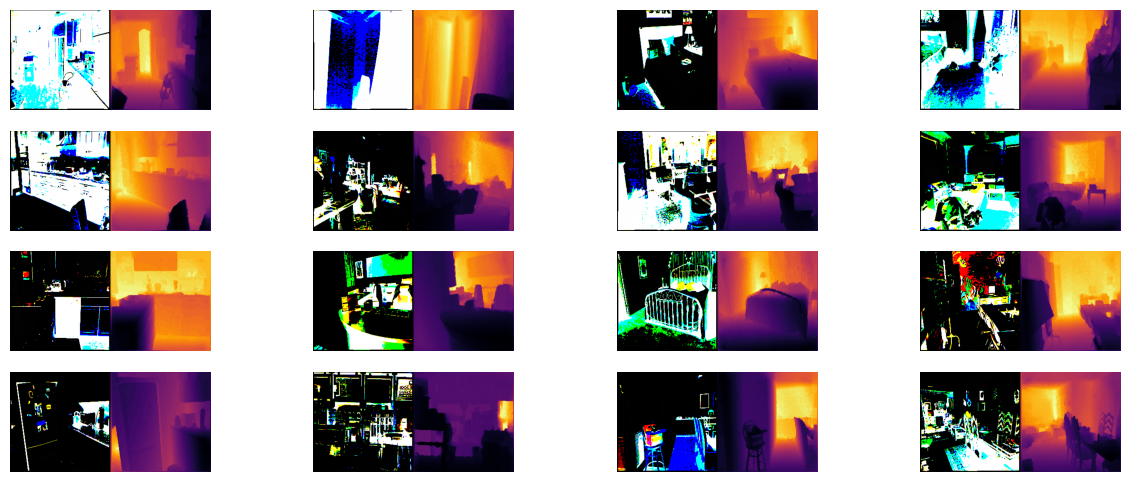

In [ ]:
randoms = [test_ds[idx] for idx in range(16)]
plt.figure(figsize=(15, 6))
for i, (img,mask) in enumerate(randoms):
    ax = plt.subplot(4, 4, i + 1)
    img, mask = img.permute(1,2,0).numpy(), mask.permute(1,2,0).numpy()
    mask = colored_depthmap(np.squeeze(mask))
    image_viz = np.hstack([img,mask])
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds,shuffle=True,batch_size=64)
val_dl = torch.utils.data.DataLoader(val_ds,shuffle=False,batch_size=64)
test_dl = torch.utils.data.DataLoader(test_ds, shuffle=True, batch_size=4)
len(train_dl), len(val_dl), len(test_dl)

(157, 16, 127)

In [ ]:
class UNet(nn.Module):
    def __init__(self,):
        super().__init__()
        self.model = smp.UnetPlusPlus(
            encoder_name='resnext50_32x4d',
            in_channels=3,
            classes=1
        )

    def trainable_encoder(self,trainable=True):
        for p in self.model.encoder.parameters():
            p.requires_grad = trainable

    def forward(self,x):
        return self.model(x)

    def _num_params(self,):
        return sum([p.numel() for p in self.model.parameters() if p.requires_grad])

In [ ]:
class UnNormalize(Normalize):
    def __init__(self,*args,**kwargs):
        mean=(0.485, 0.456, 0.406)
        std=(0.229, 0.224, 0.225)
        new_mean = [-m/s for m,s in zip(mean,std)]
        new_std = [1/s for s in std]
        super().__init__(new_mean, new_std, *args, **kwargs)

@torch.no_grad()
def plot_vals(imgs, preds, targets,n=4,figsize=(6,2),title=''):
    plt.figure(figsize=figsize,dpi=150)
    r = 2 if n == 4 else 8
    c = 2
    for i,idx in enumerate(np.random.randint(0,imgs.size(0),(n,))):
        ax = plt.subplot(r,c,i + 1)
        img,pred,gt = imgs[idx], preds[idx], targets[idx]
        img = UnNormalize()(img)*255.
        img,pred,gt = img.permute(1,2,0).numpy(), pred.permute(1,2,0).numpy(), gt.permute(1,2,0).numpy()
        pred = colored_depthmap(np.squeeze(pred))
        gt = colored_depthmap(np.squeeze(gt))
        image_viz = np.hstack([img,pred,gt])
        plt.imshow(image_viz.astype("uint8"))
        plt.axis("off")
    title = f'{title}\nimage/prediction/target' if len(title)!=0 else 'image/prediction/target'
    plt.suptitle(title)
    plt.show()


In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

Looking in indexes: https://download.pytorch.org/whl/cu118
True
12.1
Tesla T4


In [ ]:
epochs = 10
freeze_epochs = 2
lr = 1e-3

device = 'cuda'

metrics = MetricCollection([
    SSIM(data_range=(0,1)),
    MSE()
]).to(device)
train_metrics = metrics.clone()
val_metrics = metrics.clone()

logs = pd.DataFrame()
logs[['loss_train','loss_val','ssim_train','ssim_val','mse_train','mse_val']]=None

model = UNet().to(device)
model.trainable_encoder(trainable=False)

loss_fn = nn.MSELoss()
optim = torch.optim.AdamW(model.parameters(),lr=lr / 25.,weight_decay=0.02)
sched = torch.optim.lr_scheduler.OneCycleLR(optim,max_lr=lr,epochs=epochs,steps_per_epoch=(len(train_dl)))

scaler = GradScaler()

<ipython-input-16-16709d4d7ae5>:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


training decoder only


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

<ipython-input-17-298c1479217e>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-17-298c1479217e>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train loss_val ssim_train  ssim_val mse_train   mse_val
0   0.130168  0.01609   0.182799  0.330092  0.130711  0.016113




<ipython-input-17-298c1479217e>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


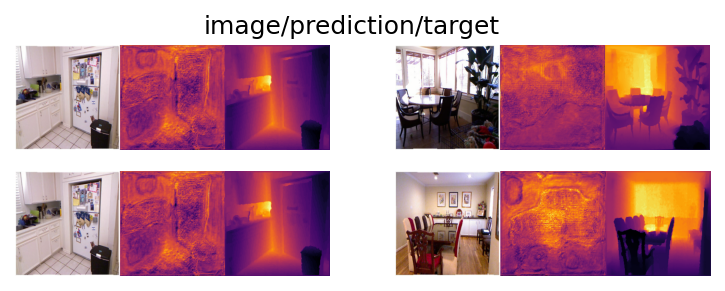

  0%|          | 0/157 [00:00<?, ?it/s]

<ipython-input-17-298c1479217e>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-17-298c1479217e>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train loss_val ssim_train  ssim_val mse_train   mse_val
1   0.015449  0.01045   0.584874  0.625262  0.015459  0.010468




<ipython-input-17-298c1479217e>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


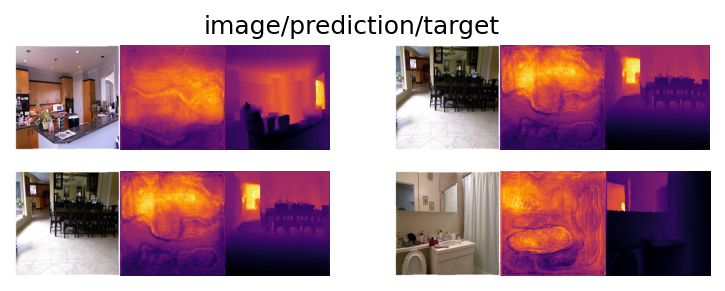

training encoder and decoder both


  0%|          | 0/157 [00:00<?, ?it/s]

<ipython-input-17-298c1479217e>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-17-298c1479217e>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
2   0.015176  0.014045     0.7311  0.713432  0.015193  0.014058




<ipython-input-17-298c1479217e>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


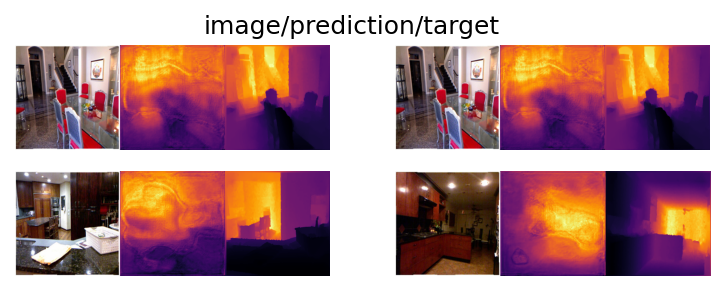

  0%|          | 0/157 [00:00<?, ?it/s]

<ipython-input-17-298c1479217e>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-17-298c1479217e>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
3   0.012817  0.008679   0.784488  0.785388  0.012792  0.008681




<ipython-input-17-298c1479217e>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


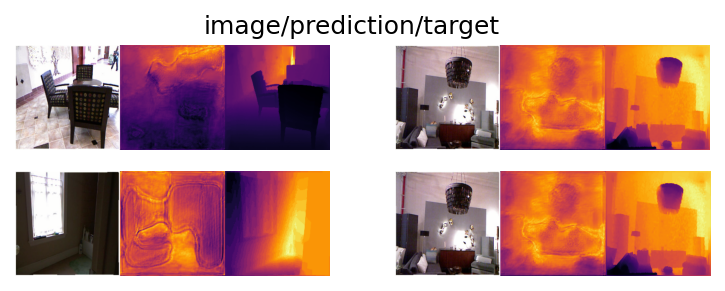

  0%|          | 0/157 [00:00<?, ?it/s]

<ipython-input-17-298c1479217e>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-17-298c1479217e>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
4   0.011593  0.007097   0.806905  0.816333  0.011594  0.007095




<ipython-input-17-298c1479217e>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


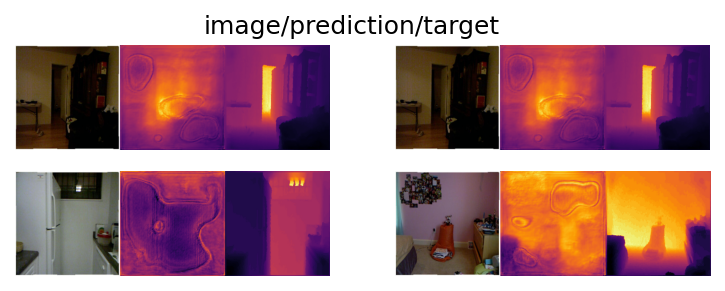

  0%|          | 0/157 [00:00<?, ?it/s]

<ipython-input-17-298c1479217e>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-17-298c1479217e>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
5   0.010157  0.005726   0.827279  0.832584  0.010154  0.005744




<ipython-input-17-298c1479217e>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


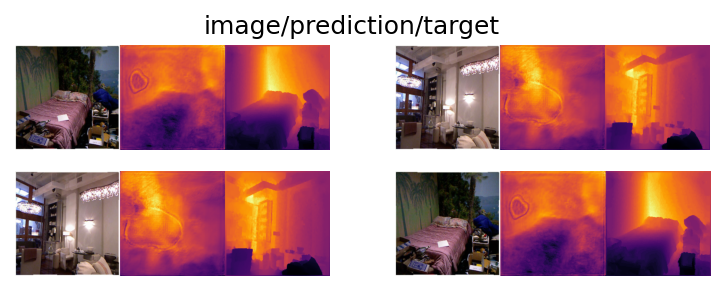

  0%|          | 0/157 [00:00<?, ?it/s]

<ipython-input-17-298c1479217e>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-17-298c1479217e>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
6   0.008975  0.005403   0.839051  0.836171  0.008993  0.005397




<ipython-input-17-298c1479217e>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


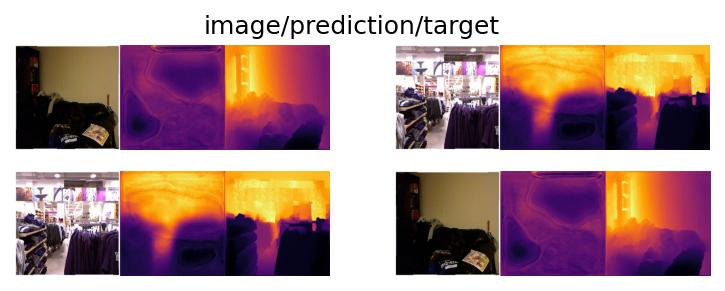

  0%|          | 0/157 [00:00<?, ?it/s]

<ipython-input-17-298c1479217e>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-17-298c1479217e>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
7   0.007525  0.004218   0.848363  0.849225  0.007528  0.004233




<ipython-input-17-298c1479217e>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


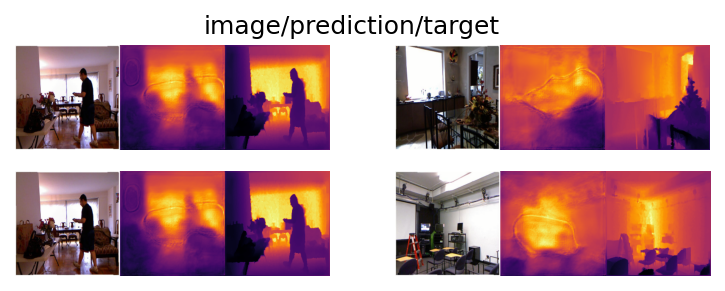

  0%|          | 0/157 [00:00<?, ?it/s]

<ipython-input-17-298c1479217e>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-17-298c1479217e>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
8   0.006808  0.003971   0.854729  0.852513  0.006817  0.003981




<ipython-input-17-298c1479217e>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


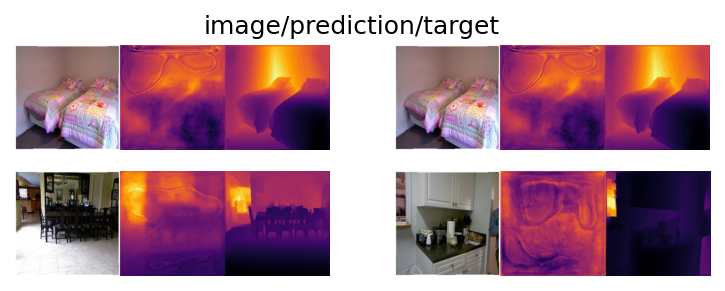

  0%|          | 0/157 [00:00<?, ?it/s]

<ipython-input-17-298c1479217e>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-17-298c1479217e>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train loss_val ssim_train  ssim_val mse_train   mse_val
9   0.006357  0.00413   0.856423  0.855415  0.006354  0.004143




<ipython-input-17-298c1479217e>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


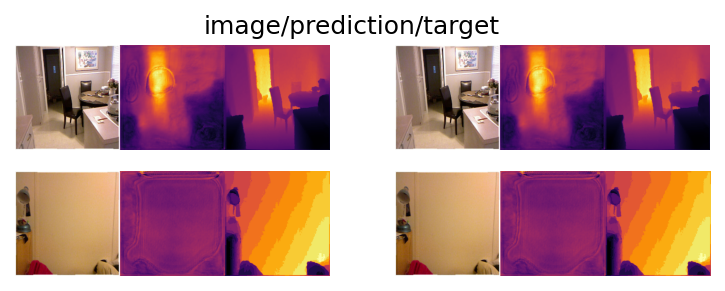

In [ ]:
best_ssim = -1e9
best_epoch = -1

print('training decoder only')

for epoch in tqdm(range(epochs)):

    model.train()

    if epoch == freeze_epochs:
        model.trainable_encoder(trainable=True)
        print('training encoder and decoder both')

    running_loss = 0.
    train_prog = tqdm(train_dl,total=len(train_dl))

    for img, mask in train_prog:

        with autocast():
            img, mask = img.to(device), mask.to(device)
            preds = model(img)

            loss = loss_fn(preds,mask)
            scaler.scale(loss).backward()
            scaler.unscale_(optim)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            scaler.step(optim)
            scaler.update()
            sched.step()
            optim.zero_grad()

            running_loss += loss.item()

            train_prog.set_description(f'loss: {loss.item():.3f}')
            train_metrics(preds,mask)

        del img, mask, preds, loss

    m = train_metrics.compute()
    _ssim,_mse = m['StructuralSimilarityIndexMeasure'].cpu().item(), m['MeanSquaredError'].cpu().item()
    logs.loc[epoch,['loss_train','ssim_train','mse_train']] = (running_loss/len(train_dl),_ssim,_mse)
    train_metrics.reset()
    model.eval()

    with torch.no_grad():

        running_loss = 0.

        val_prog = tqdm(val_dl,total=len(val_dl))
        for img, mask in val_prog:

            with autocast():
                img, mask = img.to(device), mask.to(device)
                preds = model(img)
                loss = loss_fn(preds,mask)
                running_loss += loss.item()
                val_prog.set_description(f'loss: {loss.item():.3f}')

                val_metrics(preds, mask)

            del img, mask, preds, loss

        m = val_metrics.compute()
        _ssim,_mse = m['StructuralSimilarityIndexMeasure'].cpu().item(), m['MeanSquaredError'].cpu().item()
        logs.loc[epoch,['loss_val','ssim_val','mse_val']] = (running_loss/len(val_dl),_ssim,_mse)
        val_metrics.reset()

    if _ssim > best_ssim:
        best_ssim = _ssim
        best_epoch = epoch
        sd = model.state_dict()
        torch.save(sd,'nyu-v2-depth-resnext50_32x4d-unetplusplus.pt')

    print(f"\n\n{logs.tail(1)}\n\n")

    with torch.no_grad():
        with autocast():
            img, mask = next(iter(test_dl))
            img, mask = img.to(device), mask.to(device)
            preds = model(img)
            plot_vals(
                img.cpu(),
                preds.cpu(),
                mask.cpu()
            )

    gc.collect()
    torch.cuda.empty_cache()


Evaluating on the test set...



  0%|          | 0/127 [00:00<?, ?it/s]

<ipython-input-18-ae3c3254f94e>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Test Loss: 0.0042
Test SSIM: 0.8536
Test MSE: 0.0042

Visualizing results from the test set...



<ipython-input-18-ae3c3254f94e>:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


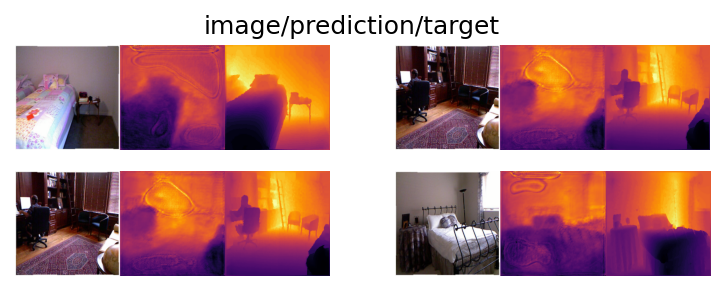


Training logs saved to 'training_logs.csv'.


Final model saved to 'nyu-v2-depth-final.pt'.


Training Summary:
Best SSIM: 0.8554 achieved at epoch 9.
Final Test SSIM: 0.8536
Final Test MSE: 0.0042


In [ ]:
# Final evaluation on the test set
print("\nEvaluating on the test set...\n")
test_metrics = metrics.clone().to(device)


model.eval()
with torch.no_grad():
    running_loss = 0.
    test_prog = tqdm(test_dl, total=len(test_dl))

    for img, mask in test_prog:
        with autocast():
            img, mask = img.to(device), mask.to(device)
            preds = model(img)
            loss = loss_fn(preds, mask)
            running_loss += loss.item()
            test_prog.set_description(f'loss: {loss.item():.3f}')

            # Compute test metrics
            test_metrics(preds, mask)

        del img, mask, preds, loss

    # Compute final test metrics
    test_results = test_metrics.compute()
    ssim_test = test_results['StructuralSimilarityIndexMeasure'].cpu().item()
    mse_test = test_results['MeanSquaredError'].cpu().item()
    test_metrics.reset()

    print(f"\nTest Loss: {running_loss / len(test_dl):.4f}")
    print(f"Test SSIM: {ssim_test:.4f}")
    print(f"Test MSE: {mse_test:.4f}")

# Visualize results from the test set
print("\nVisualizing results from the test set...\n")
with torch.no_grad():
    with autocast():
        img, mask = next(iter(test_dl))
        img, mask = img.to(device), mask.to(device)
        preds = model(img)

        # Plot a subset of images
        plot_vals(
            img.cpu(),
            preds.cpu(),
            mask.cpu()
        )

# Save logs to a file
logs.to_csv('training_logs.csv', index=False)
print(f"\nTraining logs saved to 'training_logs.csv'.\n")

# Save final model
final_model_path = 'nyu-v2-depth-final.pt'
torch.save(model.state_dict(), final_model_path)
print(f"\nFinal model saved to '{final_model_path}'.\n")

# Summary of training
print("\nTraining Summary:")
print(f"Best SSIM: {best_ssim:.4f} achieved at epoch {best_epoch}.")
print(f"Final Test SSIM: {ssim_test:.4f}")
print(f"Final Test MSE: {mse_test:.4f}")